* This notebook contains simulation of the quantum dynamics in the radical-pair mechanism in the case when the hyperfine interaction is described via nuclear spin operator.

* Here, the dynamics is governed by a two-spin Hamiltonian
$$
        \hat{H}=2\mu_B\left(\hat{\mathbf{S}}_1+\hat{\mathbf{S}}_2\right)\cdot\mathbf{B}+\hat{\mathbf{S}}_1\cdot\hat{A}\cdot\hat{\mathbf{I}},
$$
where
$$
    \hat{\mathbf{S}}_1\cdot\hat{A}\cdot\hat{\mathbf{I}}=A_x\hat{S}_{1x}\hat{I}_x+A_y\hat{S}_{1y}\hat{I}_y+A_z\hat{S}_{1z}\hat{I}_z,
$$
and $A_x, A_y, A_z$ are the eigenvalues of $\hat{A}$.

* Whenever we introduce an RF field, it is perpendicular to the DC field.
***

# Setup
The quantum simulation is done in QuTiP and we're also using numpy

In [1]:
from matplotlib import pyplot as plt
from qutip import *
import numpy as np
from pylab import pad

### Physical constants and parameters
We set $\hbar = 1$. When factor = 1, the energy is in units of eV and the Magnetic field is in units of Tesla.
Setting factor = 1e-6, converts the units in such way that the time has units of $\mu$s. Instead of defining the nuclear magnetic field explicitely, we use the corresponding hyperfine tensor component in the Hamiltonian.

In [2]:
factor = 1e-6  # uncomment for micro units
hbar = 1
pi = np.pi

# Bohr magneton in eV/Tesla
muB = 5.788e-5

# factor = 1   # uncomment for SI units
gama = muB * 0.1519756e16 * factor  # in sec-1/Tesla (Converted using natural units, by taking hbar=1)

# Geomagnetic field in Tesla
Bgeo = 47e-6

# Disturbing RF field of strength 150 nanoTesla
Brf = 150e-9

# RF frequency (corresponding to the Geomagnetic field Larmor frequency)
w = 2 * gama * Bgeo

# Yield decay rate
k = 1e4 * factor

# Hyperfine tensor components
Az = 1e-8 * 0.1519756e16 * factor
Ax = Az/2
Ay = Az/2

### Define quantum states.
The radical pair itself is descrbed in a 4D basis of tensor products of up/down basis of individual spins.

In [3]:
up = basis(2, 0)
down = basis(2, 1)
S = (tensor(up, down) - tensor(down, up)).unit()  # Singlet state
T0 = (tensor(up, down) + tensor(down, up)).unit()  # Triplet state with zero spin projection
Tu = tensor(up, up)  # Triplet state with spin projection +1
Td = tensor(down, down)  # Triplet state with spin projection -1

### Add the nuclear spin state to the basis, together with two shelving (steady-state) states corresponding to the singlet and triplet yield.
All states are written as $|\ \rangle_{I} \otimes |\ \rangle_{1} \otimes |\ \rangle_{2}$
With these states the number of dimensions is $2\times4 + 2 = 10$, so we expand the singlet and triplet states with "pad".

In [4]:
uTu = Qobj(pad(tensor(up, Tu).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=+1
uT0 = Qobj(pad(tensor(up, T0).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=0
uTd = Qobj(pad(tensor(up, Td).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & triplet with m=-1
uS = Qobj(pad(tensor(up, S).unit(), ((0, 2), (0, 0))))  # Nuclear spin up & singlet
dTu = Qobj(pad(tensor(down, Tu).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=+1
dT0 = Qobj(pad(tensor(down, T0).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=0
dTd = Qobj(pad(tensor(down, Td).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & triplet with m=-1
dS = Qobj(pad(tensor(down, S).unit(), ((0, 2), (0, 0))))  # Nuclear spin down & singlet
SYield = basis(10, 8)  # shelving state for the singlet yield after recombination
TYield = basis(10, 9)  # shelving state for the triplet yield after recombination

SY = ket2dm(SYield)

# Defining Projection operators
P1 = SYield * uS.dag() * np.sqrt(k)
P2 = TYield * uT0.dag() * np.sqrt(k)
P3 = TYield * uTu.dag() * np.sqrt(k)
P4 = TYield * uTd.dag() * np.sqrt(k)
P5 = SYield * dS.dag() * np.sqrt(k)
P6 = TYield * dT0.dag() * np.sqrt(k)
P7 = TYield * dTu.dag() * np.sqrt(k)
P8 = TYield * dTd.dag() * np.sqrt(k)

c_op_list = [P1, P2, P3, P4, P5, P6, P7, P8]  # putting them together in a list

### Operators in terms of the basis states:

In [5]:
# Electron Zeeman operators. First operator in tensor products always corresponds to the nucleus
S1x = tensor(qeye(2), sigmax(), qeye(2))  # Sx operator for electron 1: 1 x Sx x 1#
S2x = tensor(qeye(2), qeye(2), sigmax())  # Sx operator for electron 2: 1 x 1 x Sx #
Sx = S1x + S2x  # Total Sx operator
Sx = Qobj(pad(Sx.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

S1y = tensor(qeye(2), sigmay(), qeye(2))  # Sy operator for electron 1: 1 x Sy x 1
S2y = tensor(qeye(2), qeye(2), sigmay())  # Sy operator for electron 2: 1 x 1 x Sy
Sy = S1y + S2y  # Total Sy operator
Sy = Qobj(pad(Sy.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

S1z = tensor(qeye(2), sigmaz(), qeye(2))  # Sz operator for electron 1: 1 x Sz x 1
S2z = tensor(qeye(2), qeye(2), sigmaz())  # Sz operator for electron 2: 1 x 1 x Sz
Sz = S1z + S2z  # Total Sz operator
Sz = Qobj(pad(Sz.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))  # make it 10 dimensional

# Hyperfine operators
ISx = tensor(sigmax(), qeye(2), sigmax())  # Ix x 1 x Sx
ISy = tensor(sigmay(), qeye(2), sigmay())  # Iy x 1 x Sy
ISz = tensor(sigmaz(), qeye(2), sigmaz())  # Iz x 1 x Sz
ISx = Qobj(pad(ISx.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional
ISy = Qobj(pad(ISy.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional
ISz = Qobj(pad(ISz.full(), ((0, 2), (0, 2)), 'constant', constant_values=0))  # make it 10-dimensional

### DC and RF Hamiltonians.


In [6]:
# Hyperfine Interaction
Hhf = (Ax * ISx + Ay * ISy + Az * ISz)

# DC Hamiltonian
def H0(theta: float) -> object:
    # Zeeman Hamiltonian
    Bx = Bgeo * np.sin(theta)
    By = 0
    Bz = Bgeo * np.cos(theta)
    Hz = gama * (Sx * Bx + Sy * By + Sz * Bz)
    return Hz + Hhf

# Arguments of the RF field
args = {'A': Brf, 'freq': w}

# RF field
def Bt(t, args):
    A = args['A']  # amplitude of the oscilating field
    freq = args['freq']  # frequency of the oscilating field
    return A * np.cos(t * freq)

# RF Hamiltonian
def H_RF(theta, args):
    th_rf = theta + np.pi / 2.
    Bxrf = np.sin(th_rf)
    Byrf = 0.0
    Bzrf = np.cos(th_rf)
    Hrf = gama * (Sx * Bxrf + Sy * Byrf + Sz * Bzrf)
    return [Hrf, Bt]  # Time-dependent Hamiltonian H(t)



# Calculate the singlet population and both yields due to recombination vs time

In [7]:
theta = 0 * pi
tlist = np.linspace(0.0, 6.0 / k, 20000) #time grid
rho0 = 0.5 * ket2dm(uS) + 0.5 * ket2dm(dS)  # Initial density matrix: singlet state with nuclear spin up and down

result_t_DC = mesolve(H0(theta), rho0, tlist, c_op_list, [2 * rho0, SY], args=args)
result_t_RF = mesolve([H0(theta), H_RF(theta, args)], rho0, tlist, c_op_list, [2 * rho0, SY], args=args)

singlet_population_DC = result_t_DC.expect[0]
singlet_population_RF = result_t_RF.expect[0]


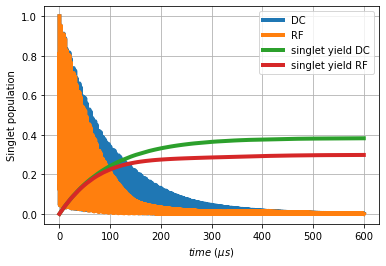

In [8]:
#Plot results
fig, ax = plt.subplots()
ax.plot(tlist * 1e6 * factor, singlet_population_DC, label='DC', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, singlet_population_RF, label='RF', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, result_t_DC.expect[1], label='singlet yield DC', linewidth=4.0)
ax.plot(tlist * 1e6 * factor, result_t_RF.expect[1], label='singlet yield RF', linewidth=4.0)
ax.set_xlabel(r'$time\ (\mu s)$')
ax.set_ylabel('Singlet population')
ax.legend(loc=0)
ax.grid()

# Yields vs $\theta$
Here the yield is determined as the steady-state population of the shelving state. Basically, we need to wait long enough. We calculate for both orientation of the nuclear field and use their average.

In [9]:
thetas = np.linspace(0.0, pi, 21)
tlist = np.linspace(0.0, 6.0 / k, 20000)

### DC field

In [10]:
singlet_yield_DC = []

rho0 = 0.5 * ket2dm(uS) + 0.5 * ket2dm(dS)

print("DC evolution nuclear field")
for th in thetas:
    print(r"$\theta$ = ", th)
    result_DC = mesolve(H0(th), rho0, tlist, c_op_list, [SY])
    singlet_yield_DC.append(result_DC.expect[0][-1])

# convert to numpy array
singlet_yield_DC = np.array(singlet_yield_DC)

DC evolution nuclear field
$\theta$ =  0.0
$\theta$ =  0.15707963267948966
$\theta$ =  0.3141592653589793
$\theta$ =  0.47123889803846897
$\theta$ =  0.6283185307179586
$\theta$ =  0.7853981633974483
$\theta$ =  0.9424777960769379
$\theta$ =  1.0995574287564276
$\theta$ =  1.2566370614359172
$\theta$ =  1.413716694115407
$\theta$ =  1.5707963267948966
$\theta$ =  1.7278759594743862
$\theta$ =  1.8849555921538759
$\theta$ =  2.0420352248333655
$\theta$ =  2.199114857512855
$\theta$ =  2.356194490192345
$\theta$ =  2.5132741228718345
$\theta$ =  2.670353755551324
$\theta$ =  2.827433388230814
$\theta$ =  2.9845130209103035
$\theta$ =  3.141592653589793


### DC + RF

In [11]:
singlet_yield_RF = []

# Defining initial density matrix
rho0 = 0.5 * ket2dm(uS) + 0.5 * ket2dm(dS)  # density matrix for singlet with nuclear spin up and down

print("Nuclear operator RF evolution")
for th in thetas:
    print(r'$ \theta = $' + str(th))
    result_RF = mesolve([H0(th), H_RF(th, args)], rho0, tlist, c_op_list, [SY], args=args)
    singlet_yield_RF.append(result_RF.expect[0][-1])

singlet_yield_RF = np.array(singlet_yield_RF)

Nuclear operator RF evolution
$ \theta = $0.0
$ \theta = $0.15707963267948966
$ \theta = $0.3141592653589793
$ \theta = $0.47123889803846897
$ \theta = $0.6283185307179586
$ \theta = $0.7853981633974483
$ \theta = $0.9424777960769379
$ \theta = $1.0995574287564276
$ \theta = $1.2566370614359172
$ \theta = $1.413716694115407
$ \theta = $1.5707963267948966
$ \theta = $1.7278759594743862
$ \theta = $1.8849555921538759
$ \theta = $2.0420352248333655
$ \theta = $2.199114857512855
$ \theta = $2.356194490192345
$ \theta = $2.5132741228718345
$ \theta = $2.670353755551324
$ \theta = $2.827433388230814
$ \theta = $2.9845130209103035
$ \theta = $3.141592653589793


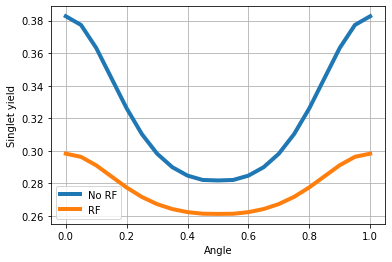

In [12]:
# Plot
fig, ax = plt.subplots()
ax.plot(thetas / pi, singlet_yield_DC, label='No RF', linewidth=4.0)
ax.plot(thetas / pi, singlet_yield_RF, label='RF', linewidth=4.0)
ax.set_xlabel('Angle')
ax.set_ylabel('Singlet yield')
ax.legend(loc=0)
ax.grid()